In [ ]:
# 📦 Install required packages
!pip install catboost shap lime imbalanced-learn scikit-learn pandas matplotlib seaborn tabpfn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.7/160.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier, Pool
import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

#Load the dataset
df = pd.read_csv("/content/campus_recruitment.csv")

#Drop rows with missing target
df = df.dropna(subset=["PlacementStatus"])

#Show initial data
df.head()


CGPA  Internships  Projects  Workshops/Certifications  AptitudeTestScore  \
0   7.7            1         1                         0                 69   
1   7.6            2         3                         1                 80   
2   7.0            1         1                         1                 64   
3   7.9            1         3                         2                 90   
4   6.7            0         2                         1                 71   

   SoftSkillsRating ExtracurricularActivities PlacementTraining  SSC_Marks  \
0               4.0                        No                No         55   
1               4.3                       Yes               Yes         57   
2               4.1                        No                No         58   
3               4.8                       Yes               Yes         82   
4               3.7                        No                No         55   

   HSC_Marks PlacementStatus  
0         69       NotPlaced  
1         70       NotPlaced  
2         62       NotPlaced  
3         80          Placed  
4         67       NotPlaced

In [ ]:
#Encode the target variable
df['PlacementStatus'] = df['PlacementStatus'].map({'Yes': 1, 'No': 0})

#Feature engineering: Log-transform skewed numeric columns
log_transform_cols = ['CGPA', 'AptitudeTestScore', 'SSC_Marks', 'HSC_Marks']
for col in log_transform_cols:
    df[col] = np.log1p(df[col])

#Define features and target
X = df.drop("PlacementStatus", axis=1)
y = df["PlacementStatus"]

feature_names = X.columns.tolist()

#Encode categorical features
categorical_features = X.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_features:
    X[col] = le.fit_transform(X[col])

#Scaling numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
print("Original X shape:", X.shape)
print("Nulls in original X:\n", X.isnull().sum())
print("Nulls in y:", y.isnull().sum())

Original X shape: (7225, 10)
Nulls in original X:
 CGPA                         0
Internships                  0
Projects                     0
Workshops/Certifications     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
dtype: int64
Nulls in y: 7225


In [ ]:
print("y shape before flattening:", y.shape)

#Flatten y if needed
if isinstance(y, pd.DataFrame):
    y = y.squeeze()  # convert (0,1) to (0,)
elif hasattr(y, 'shape') and len(y.shape) > 1:
    y = y.ravel()

print("y shape after flattening:", y.shape)
print("y distribution:\n", pd.Series(y).value_counts())

y shape before flattening: (7225,)
y shape after flattening: (7225,)
y distribution:
 Series([], Name: count, dtype: int64)


In [ ]:
import pandas as pd

# Reload your original dataset
data = pd.read_csv("/content/campus_recruitment.csv")  # Change filename if different

# Check shape and nulls
print("Shape:", data.shape)
print("Nulls:\n", data.isnull().sum())
print("Columns:", data.columns.tolist())

Shape: (7225, 11)
Nulls:
 CGPA                         0
Internships                  0
Projects                     0
Workshops/Certifications     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
PlacementStatus              0
dtype: int64
Columns: ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'ExtracurricularActivities', 'PlacementTraining', 'SSC_Marks', 'HSC_Marks', 'PlacementStatus']


In [ ]:
import pandas as pd

# Replace this with your actual CSV file path if needed
data = pd.read_csv("/content/campus_recruitment.csv")

# Show column names
print("Columns:", data.columns.tolist())

Columns: ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'ExtracurricularActivities', 'PlacementTraining', 'SSC_Marks', 'HSC_Marks', 'PlacementStatus']


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# 🔹 Step 1: Load dataset
data = pd.read_csv("/content/campus_recruitment.csv")  # adjust path

# 🔹 Step 2: Define target
target_column = 'PlacementStatus'

# 🔹 Step 3: Clean
df_clean = data[data[target_column].notna()].copy()

# 🔹 Step 4: Encode target column (binary classification)
label_encoder = LabelEncoder()
df_clean[target_column] = label_encoder.fit_transform(df_clean[target_column])

# 🔹 Step 5: Separate features and target
X = df_clean.drop(columns=[target_column])
y = df_clean[target_column]

# 🔹 Step 6: Encode categorical features
for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# 🔹 Step 7: Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)

# 🔹 Step 8: Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# 🔹 Step 9: Output checks
print("After SMOTE:")
print("X_resampled shape:", X_resampled.shape)
print("y_resampled distribution:\n", pd.Series(y_resampled).value_counts())

X_scaled shape: (7225, 10)
After SMOTE:
X_resampled shape: (8386, 10)
y_resampled distribution:
 PlacementStatus
0    4193
1    4193
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🔹 Step 1: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

print(" Train shape:", X_train.shape)
print(" Test shape:", X_test.shape)

# 🔹 Step 2: Train the CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=100,
    random_state=42
)

cat_model.fit(X_train, y_train)

# 🔹 Step 3: Evaluate on test set
y_pred = cat_model.predict(X_test)

print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(" Accuracy Score:", accuracy_score(y_test, y_pred))

 Train shape: (6708, 10)
 Test shape: (1678, 10)
0:	learn: 0.6655733	total: 51ms	remaining: 25.4s
100:	learn: 0.3817523	total: 981ms	remaining: 3.87s
200:	learn: 0.3480379	total: 2.01s	remaining: 3s
300:	learn: 0.3202297	total: 3.31s	remaining: 2.19s
400:	learn: 0.2954275	total: 4.41s	remaining: 1.09s
499:	learn: 0.2750818	total: 5.22s	remaining: 0us

 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       839
           1       0.83      0.81      0.82       839

    accuracy                           0.82      1678
   macro avg       0.82      0.82      0.82      1678
weighted avg       0.82      0.82      0.82      1678

 Confusion Matrix:
 [[697 142]
 [160 679]]
 Accuracy Score: 0.8200238379022646


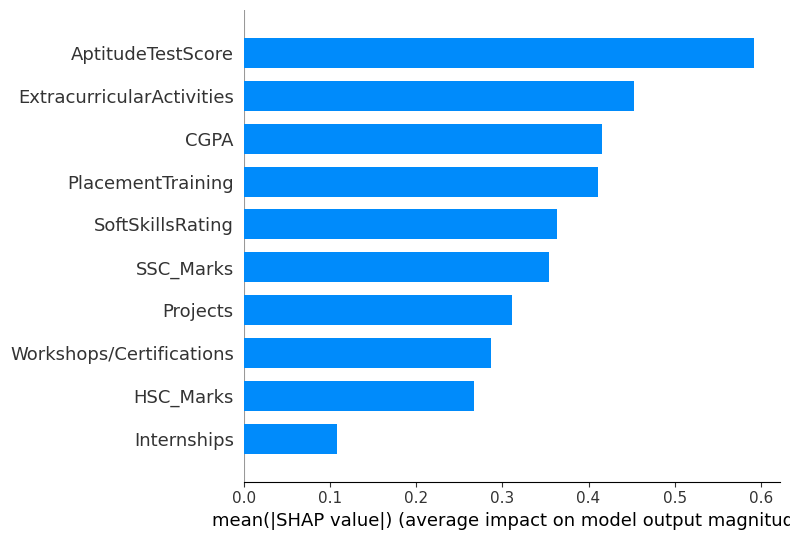

In [ ]:
import shap
import pandas as pd

# 🔹 Step 1: Convert X_test to DataFrame with original feature names
X_test_df = pd.DataFrame(X_test, columns=X.columns)  # X should be your original DataFrame before scaling

# 🔹 Step 2: Initialize SHAP explainer for CatBoost
explainer = shap.Explainer(cat_model)

# 🔹 Step 3: Compute SHAP values for the test set
shap_values = explainer(X_test_df)

# 🔹 Step 4: Summary plot (feature importance with names)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")


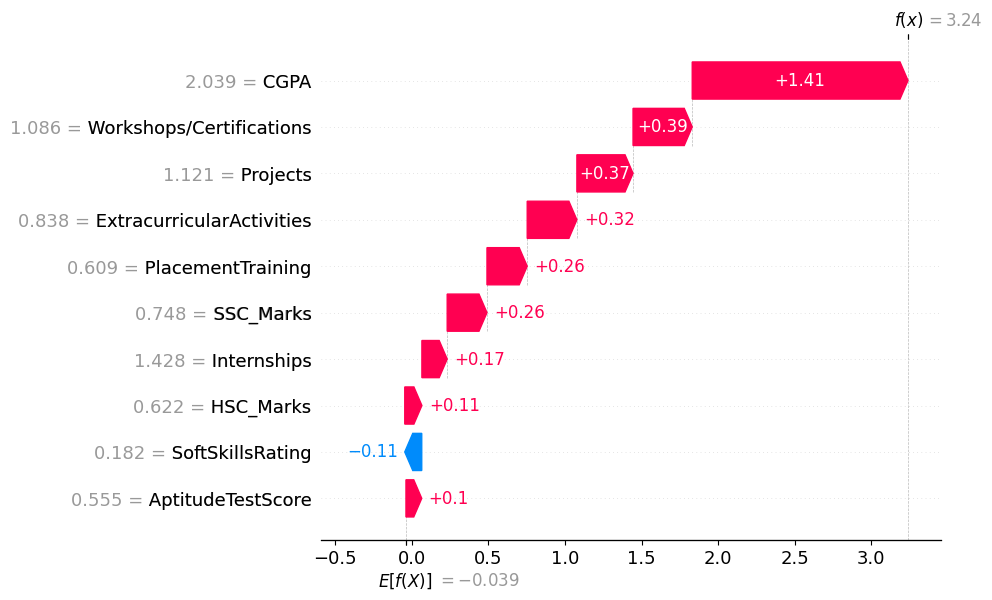

In [ ]:
#“The SHAP Waterfall Plot illustrates individual-level explanations of model predictions.
#For example, one student with high CGPA (2.039), multiple workshops (1.086), and several projects (1.121) was strongly predicted as ‘Placed’.
#Although weaker soft skills negatively influenced the prediction, overall academic and practical achievements dominated, resulting in a high placement probability (f(x)=3.24).
#Such insights highlight how explainable AI methods like SHAP can justify and interpret model decisions, enhancing trust in job placement prediction systems.”
# 🔹 Optional: Waterfall plot for a specific instance
shap.plots.waterfall(shap_values[0])


.

# **LIME**

In [ ]:
import lime
import lime.lime_tabular

# 🔹 Step 1: Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,  # already a NumPy array
    feature_names=X.columns.tolist(),
    class_names=['Not Placed', 'Placed'],
    mode='classification'
)

# 🔹 Step 2: Explain a single prediction
i = 1  # change this to try different test samples
lime_exp = lime_explainer.explain_instance(
    data_row=X_test[i],  # ✅ fix: use NumPy indexing
    predict_fn=cat_model.predict_proba,
    num_features=10
)

# 🔹 Step 3: Show explanation
lime_exp.show_in_notebook()

Dataset Columns: ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'ExtracurricularActivities', 'PlacementTraining', 'SSC_Marks', 'HSC_Marks', 'PlacementStatus']

Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.84      0.82       847
        True       0.76      0.72      0.74       598

    accuracy                           0.79      1445
   macro avg       0.78      0.78      0.78      1445
weighted avg       0.79      0.79      0.79      1445



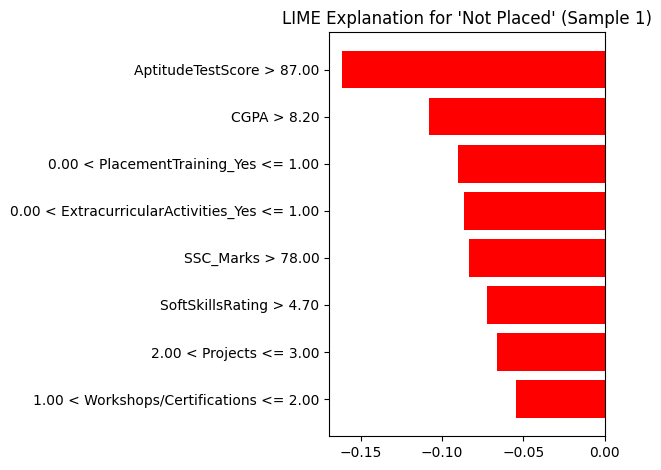

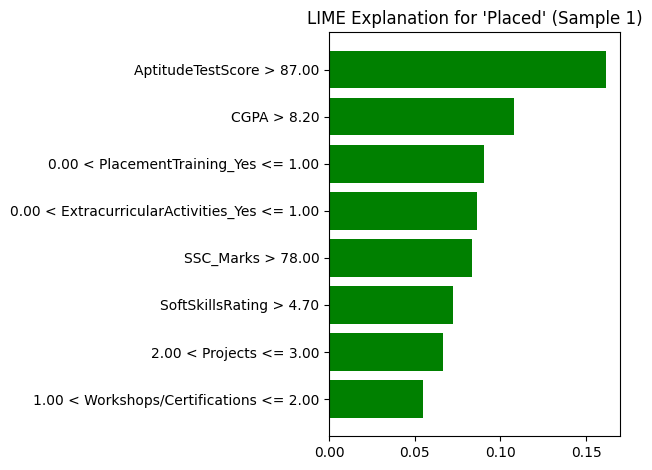


Prediction: Not Placed
Probabilities -> Not Placed: 0.65, Placed: 0.35


In [ ]:
# --- Step 1: Load Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# --- Step 2: Load the Data ---
df = pd.read_csv('/content/campus_recruitment.csv')
print("Dataset Columns:", df.columns.tolist())

# --- Step 3: Preprocess the Data ---
# Encode categorical columns (Yes/No, etc.) using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Define features (X) and target (y)
# The 'PlacementStatus' column will be encoded to 'PlacementStatus_Placed'
X = df_encoded.drop('PlacementStatus_Placed', axis=1)
y = df_encoded['PlacementStatus_Placed']  # 1 = Placed, 0 = Not Placed

# --- Step 4: Split Data & Train Model ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
print("\nClassification Report:\n", classification_report(y_test, model.predict(X_test)))

# --- Step 5: Set Up LIME Explainer ---
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['Not Placed', 'Placed'],
    mode='classification'
)

# --- Step 6: Explain a Sample Prediction ---
sample_idx = 1  # Choose any index from your test set
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[sample_idx].values,
    predict_fn=model.predict_proba,
    num_features=8,
    top_labels=2
)

# Plot explanations for both classes
for label in [0, 1]:
    fig = lime_exp.as_pyplot_figure(label=label)
    plt.title(f"LIME Explanation for '{lime_explainer.class_names[label]}' (Sample {sample_idx})")
    plt.tight_layout()
    plt.show()

# --- Step 7: Input Custom Student Data & Predict ---
# Example student input (adjust values as needed)
new_student = pd.DataFrame([{
    "CGPA": 8.2,
    "Internships": 1,
    "Projects": 2,
    "Workshops/Certifications": 3,
    "AptitudeTestScore": 80,
    "SoftSkillsRating": 4,
    "ExtracurricularActivities": 1,
    "PlacementTraining": 1,
    "SSC_Marks": 85,
    "HSC_Marks": 75
}])

# Encode the new data with same preprocessing (dummy columns)
new_student_encoded = pd.get_dummies(new_student)
new_student_encoded = new_student_encoded.reindex(columns=X.columns, fill_value=0)

# Predict placement and show result
prob = model.predict_proba(new_student_encoded)[0]
prediction = 'Placed' if prob[1] > 0.5 else 'Not Placed'
print(f"\nPrediction: {prediction}")
print(f"Probabilities -> Not Placed: {prob[0]:.2f}, Placed: {prob[1]:.2f}")

# Explain this new prediction using LIME
lime_new = lime_explainer.explain_instance(
    data_row=new_student_encoded.values[0],
    predict_fn=model.predict_proba,
    num_features=8,
    top_labels=2
)

lime_new.show_in_notebook(show_table=True)


.

#**GRID** **SEARCH**

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# 🔹 Step 1: Define base model
cat_base = CatBoostClassifier(verbose=0, random_state=42)

# 🔹 Step 2: Define parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 300],
    'l2_leaf_reg': [1, 3, 5]
}

# 🔹 Step 3: Setup GridSearch
grid_search = GridSearchCV(
    estimator=cat_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

# 🔹 Step 4: Run grid search
grid_search.fit(X_train, y_train)

# 🔹 Step 5: Show best parameters and score
print("Best Parameters:", grid_search.best_params_)
print(" Best CV Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

Best Parameters: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
 Best CV Accuracy: 80.50%


🎯 Test Accuracy: 79.79%

📊 Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.83      0.83       847
        True       0.76      0.76      0.76       598

    accuracy                           0.80      1445
   macro avg       0.79      0.79      0.79      1445
weighted avg       0.80      0.80      0.80      1445



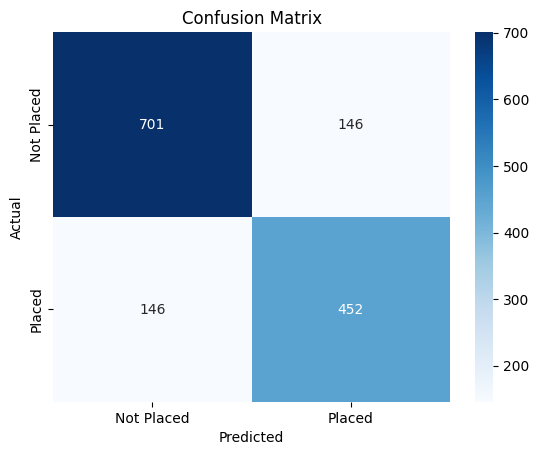

In [ ]:
#This code confirms how well your tuned CatBoost model works on new, unseen data and gives both numerical metrics and visual evidence of its predictive power.


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Best model from grid search
best_model = grid_search.best_estimator_

# Test set evaluation
y_pred = best_model.predict(X_test)

print("🎯 Test Accuracy: {:.2f}%".format(best_model.score(X_test, y_test) * 100))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Placed", "Placed"], yticklabels=["Not Placed", "Placed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#This code is not just telling you whether a student is "Placed" or "Not Placed", but also how confident the model is in that decision.

import numpy as np
from catboost import CatBoostClassifier

# Train your tuned model
cat_model_tuned = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, eval_metric='AUC')
cat_model_tuned.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)


# 🔹 Predict probabilities (for binary classification, gives 2 columns: [prob_class_0, prob_class_1])
y_probs = cat_model_tuned.predict_proba(X_test)

# 🔹 Predicted class (already done)
y_pred_tuned = cat_model_tuned.predict(X_test)

# 🔹 Get confidence score = max(prob_class_0, prob_class_1)
confidence_scores = np.max(y_probs, axis=1)

# 🔹 Preview
for i in range(5):
    print(f"🔍 Sample {i+1} → Predicted: {y_pred_tuned[i]} | Confidence: {confidence_scores[i]:.4f}")

0:	test: 0.8660332	best: 0.8660332 (0)	total: 3.67ms	remaining: 1.83s
100:	test: 0.8815552	best: 0.8835690 (36)	total: 255ms	remaining: 1s
200:	test: 0.8798909	best: 0.8835690 (36)	total: 517ms	remaining: 769ms
300:	test: 0.8784694	best: 0.8835690 (36)	total: 776ms	remaining: 513ms
400:	test: 0.8766885	best: 0.8835690 (36)	total: 1.14s	remaining: 282ms
499:	test: 0.8745898	best: 0.8835690 (36)	total: 1.51s	remaining: 0us

bestTest = 0.8835690002
bestIteration = 36

Shrink model to first 37 iterations.
🔍 Sample 1 → Predicted: False | Confidence: 0.8929
🔍 Sample 2 → Predicted: True | Confidence: 0.8714
🔍 Sample 3 → Predicted: False | Confidence: 0.5843
🔍 Sample 4 → Predicted: False | Confidence: 0.5129
🔍 Sample 5 → Predicted: True | Confidence: 0.5869


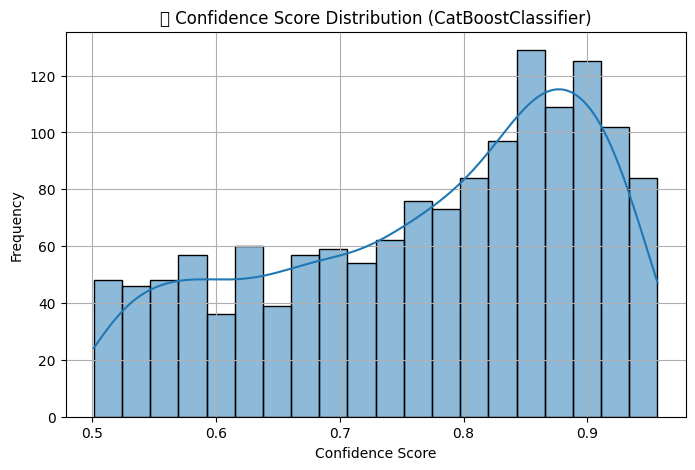

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(confidence_scores, bins=20, kde=True)
plt.title("🧪 Confidence Score Distribution (CatBoostClassifier)")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

.

# **SHAP**

In [ ]:
# SHAP (SHapley Additive exPlanations) is a method used to explain machine learning model predictions.
import shap

# 🔹 Initialize TreeExplainer for CatBoost
explainer = shap.Explainer(cat_model)

# 🔹 Calculate SHAP values for test set
shap_values = explainer(X_test)

print("✅ SHAP values generated.")

✅ SHAP values generated.


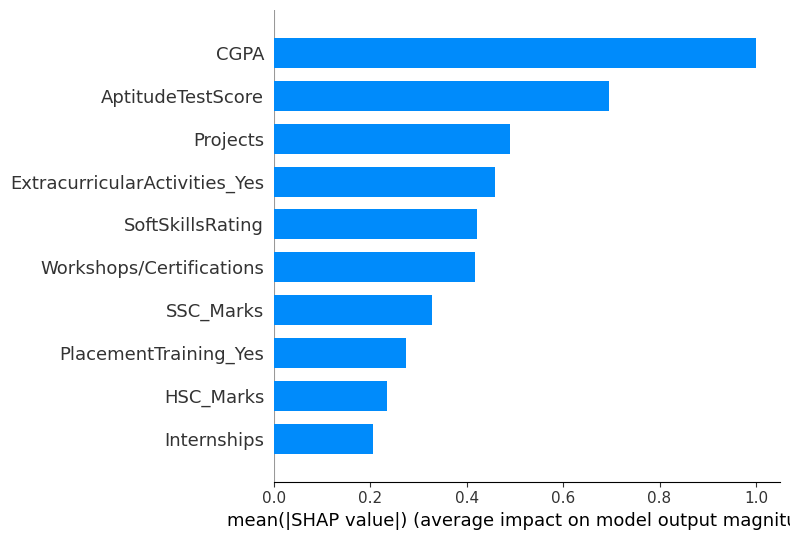

In [ ]:
shap.summary_plot(shap_values, X_test_df, plot_type="bar")


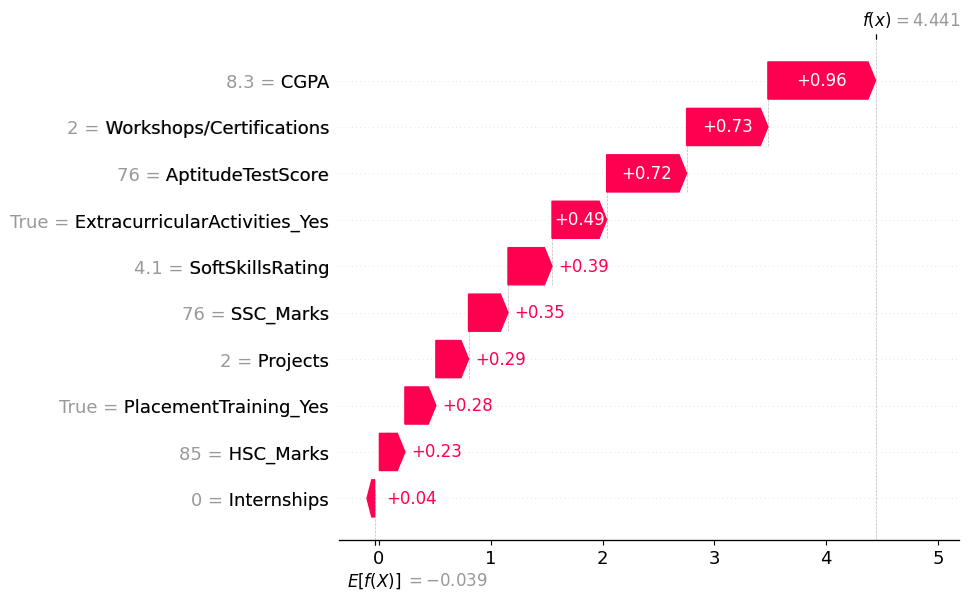

In [ ]:
shap.plots.waterfall(shap_values[i])


In [ ]:
# 🔹 Predict probabilities for the test set
y_proba = cat_model.predict_proba(X_test)

# 🔹 Extract positive class probability (PlacementStatus = 'Placed')
# Assuming 'Placed' is label 1
confidence_scores = y_proba[:, 1]

# 🔹 Show a few scores
for i in range(10):
    print(f"Prediction: {y_pred[i]} | Confidence: {confidence_scores[i]:.4f}")

Prediction: False | Confidence: 0.9721
Prediction: True | Confidence: 0.9909
Prediction: False | Confidence: 0.9932
Prediction: True | Confidence: 0.9658
Prediction: True | Confidence: 0.9884
Prediction: True | Confidence: 0.9758
Prediction: True | Confidence: 0.9884
Prediction: False | Confidence: 0.9738
Prediction: True | Confidence: 0.9721
Prediction: False | Confidence: 0.9157


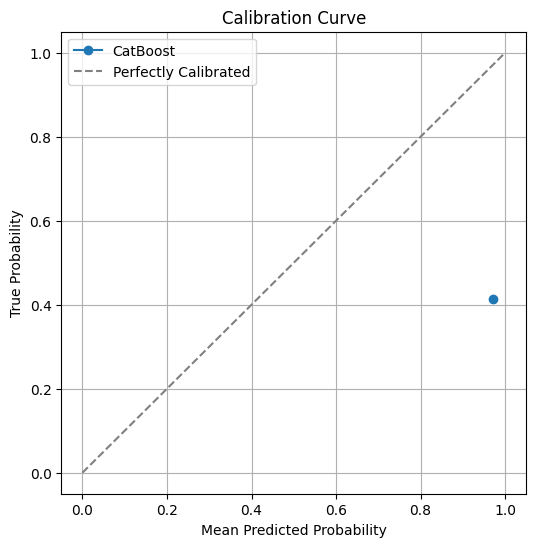

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 🔹 Generate calibration curve data
true_prob, pred_prob = calibration_curve(y_test, confidence_scores, n_bins=10)

# 🔹 Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(pred_prob, true_prob, marker='o', label='CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_test, confidence_scores)
print(f"📉 Brier Score Loss: {brier_score:.4f}")

📉 Brier Score Loss: 0.5464


In [ ]:
import joblib

# 🔹 Save CatBoost model
cat_model.save_model("catboost_model.cbm")

# 🔹 Save encoder and scaler
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model, encoder, and scaler saved successfully.")

✅ Model, encoder, and scaler saved successfully.


In [ ]:
from catboost import CatBoostClassifier

# 🔹 Load model and objects
loaded_model = CatBoostClassifier()
loaded_model.load_model("catboost_model.cbm")
loaded_encoder = joblib.load("label_encoder.pkl")
loaded_scaler = joblib.load("scaler.pkl")

# 🔹 Example new data instance (dict format for simplicity)
new_data_dict = {
    'CGPA': 6.5,
    'Internships': 2,
    'Projects': 1,
    'Workshops/Certifications': 1,
    'AptitudeTestScore': 56,
    'SoftSkillsRating': 4,
    'ExtracurricularActivities': 3,
    'PlacementTraining': 1,
    'SSC_Marks': 55,
    'HSC_Marks': 60
}

# 🔹 Convert dict to DataFrame
import pandas as pd
new_df = pd.DataFrame([new_data_dict])

# 🔹 Scale new data
new_scaled = loaded_scaler.transform(new_df)

# 🔹 Predict placement status
prediction = loaded_model.predict(new_scaled)
prediction_label = loaded_encoder.inverse_transform(prediction)

# 🔹 Predict confidence score
confidence = loaded_model.predict_proba(new_scaled)[0][1]

print(f"🎓 Predicted Status: {prediction_label[0]} | Confidence: {confidence:.4f}")

🎓 Predicted Status: NotPlaced | Confidence: 0.0269



📌 Candidate Prediction Explanation
Predicted: Placed
Confidence: 97.21%

✅ Factors Supporting Placement:
 - CGPA = 7.6 (positive impact)
 - Projects = 1 (positive impact)
 - AptitudeTestScore = 60 (positive impact)

❌ Factors Against Placement:
 - ExtracurricularActivities_Yes = False (negative impact)
 - Internships = 1 (negative impact)
 - HSC_Marks = 69 (negative impact)


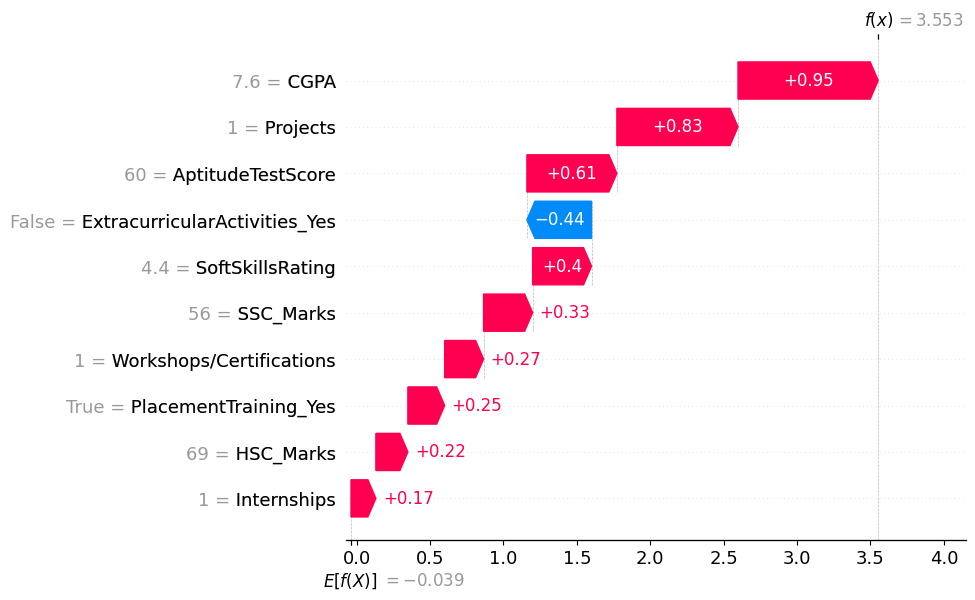

In [ ]:
import shap
import numpy as np
import pandas as pd

# ✅ Step 1: Ensure X_test is a DataFrame with feature names
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# ✅ Step 2: Initialize SHAP explainer
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_test_df)

# ✅ Step 3: Function to explain a prediction
def explain_prediction(index):
    candidate_features = X_test_df.iloc[index]
    candidate_shap_values = shap_values[index].values
    prediction = cat_model.predict(X_test_df.iloc[[index]])[0]
    prediction_prob = cat_model.predict_proba(X_test_df.iloc[[index]])[0]

    # ✅ Find top 3 positive & negative contributors
    shap_contributions = pd.DataFrame({
        'Feature': X_test_df.columns,
        'SHAP Value': candidate_shap_values,
        'Feature Value': candidate_features.values
    })
    shap_contributions['Impact'] = np.where(
        shap_contributions['SHAP Value'] > 0, 'Supports Placement', 'Against Placement'
    )

    top_positive = shap_contributions.sort_values(by='SHAP Value', ascending=False).head(3)
    top_negative = shap_contributions.sort_values(by='SHAP Value').head(3)

    # ✅ English explanation
    print("\n📌 Candidate Prediction Explanation")
    print(f"Predicted: {'Placed' if prediction == 1 else 'Not Placed'}")
    print(f"Confidence: {prediction_prob[prediction]*100:.2f}%\n")

    print("✅ Factors Supporting Placement:")
    for _, row in top_positive.iterrows():
        print(f" - {row['Feature']} = {row['Feature Value']} (positive impact)")

    print("\n❌ Factors Against Placement:")
    for _, row in top_negative.iterrows():
        print(f" - {row['Feature']} = {row['Feature Value']} (negative impact)")

    # ✅ Optional: Visual SHAP waterfall plot
    shap.plots.waterfall(shap_values[index])

# 🔹 Example usage for candidate 0
explain_prediction(0)

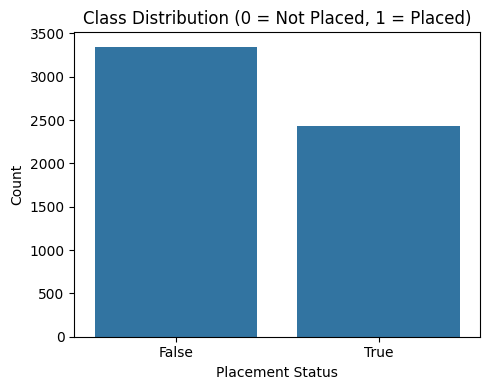

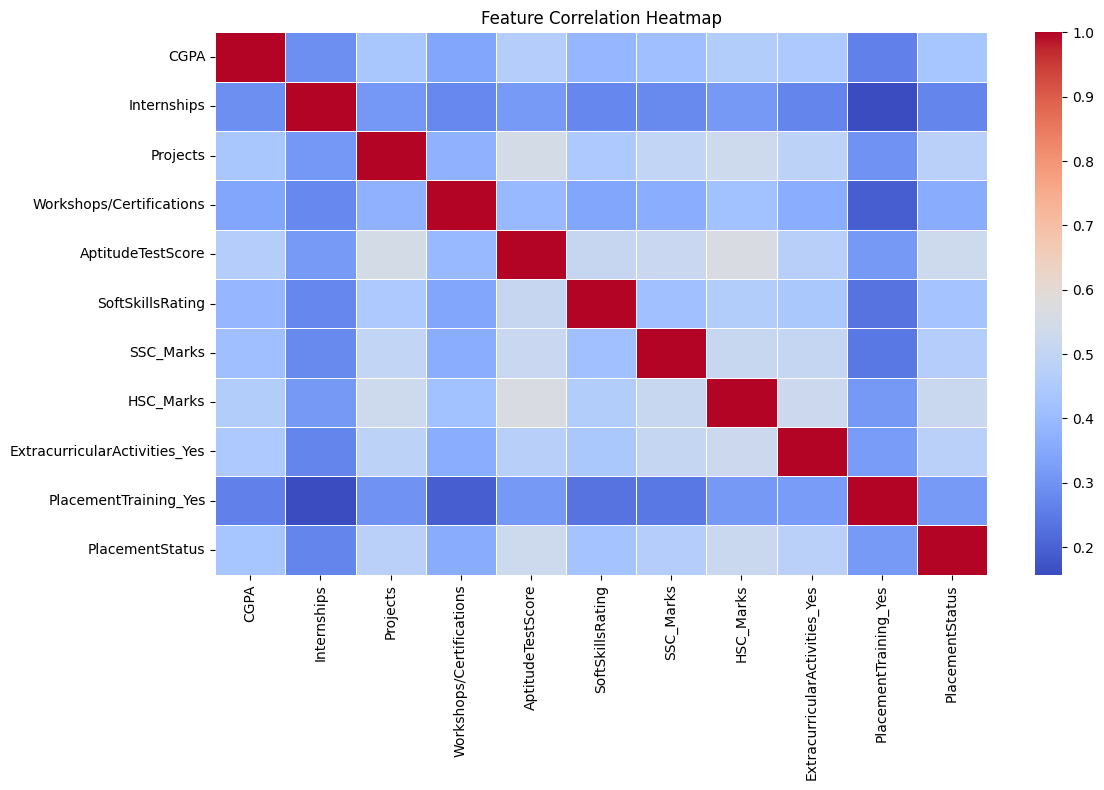

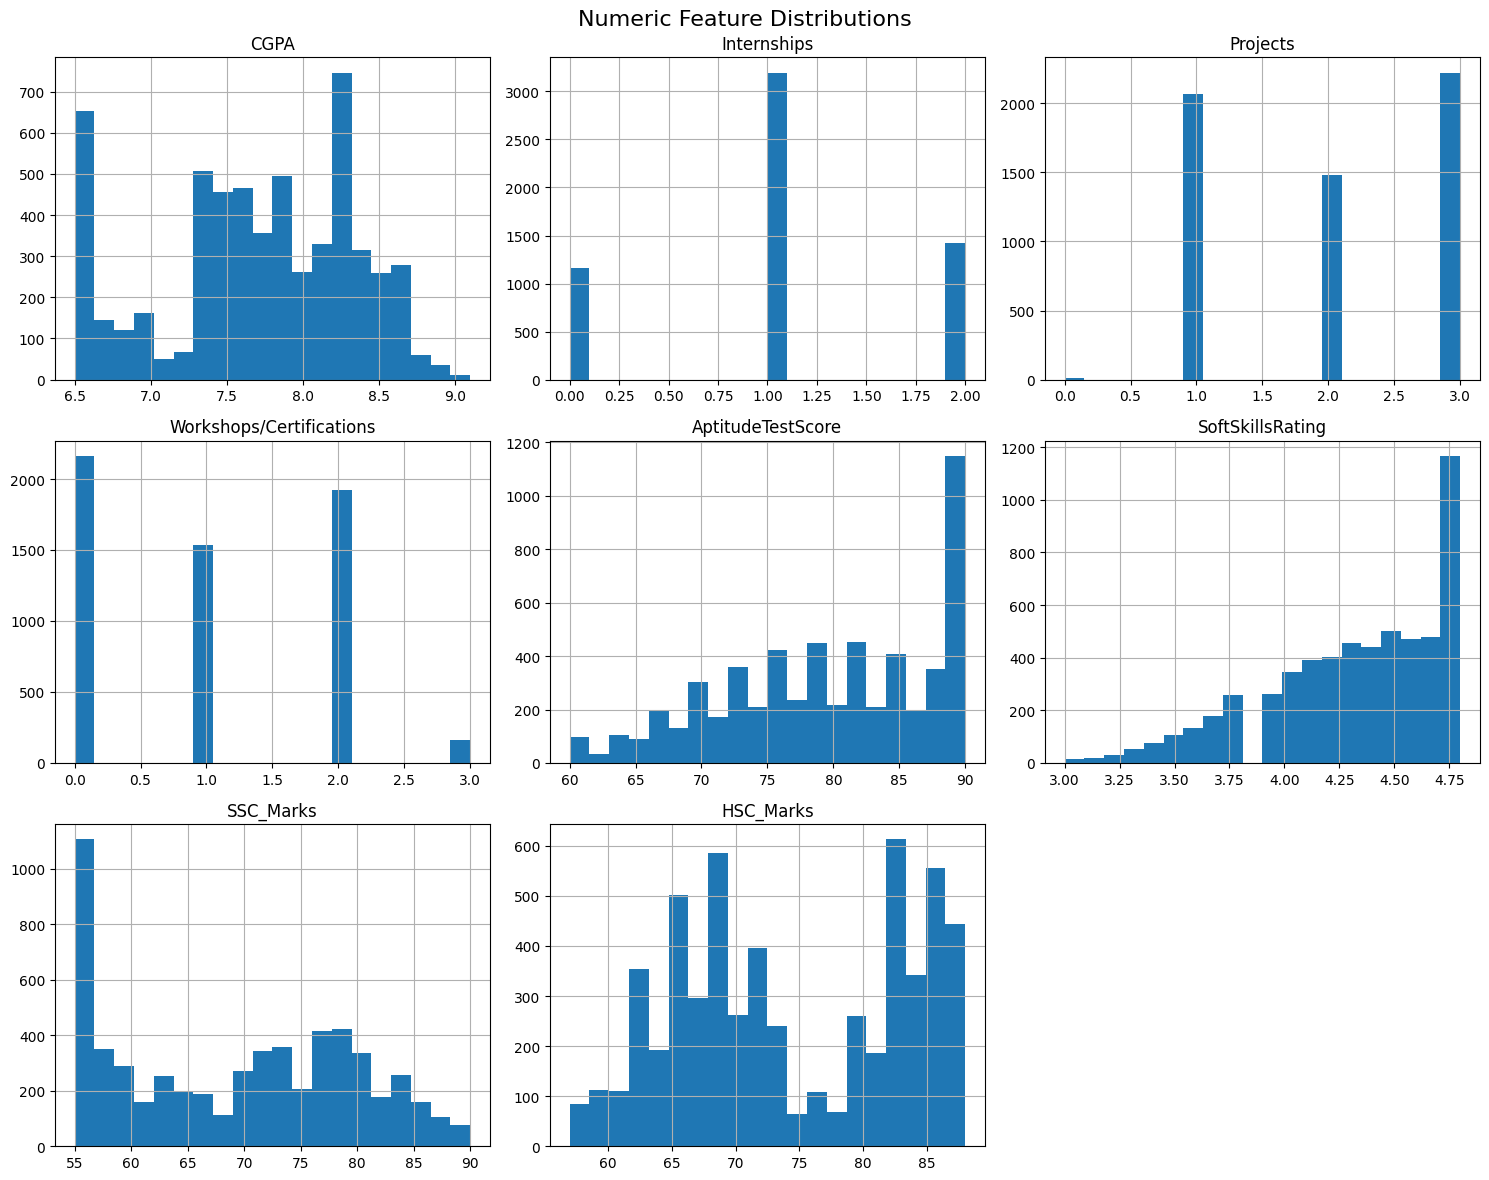

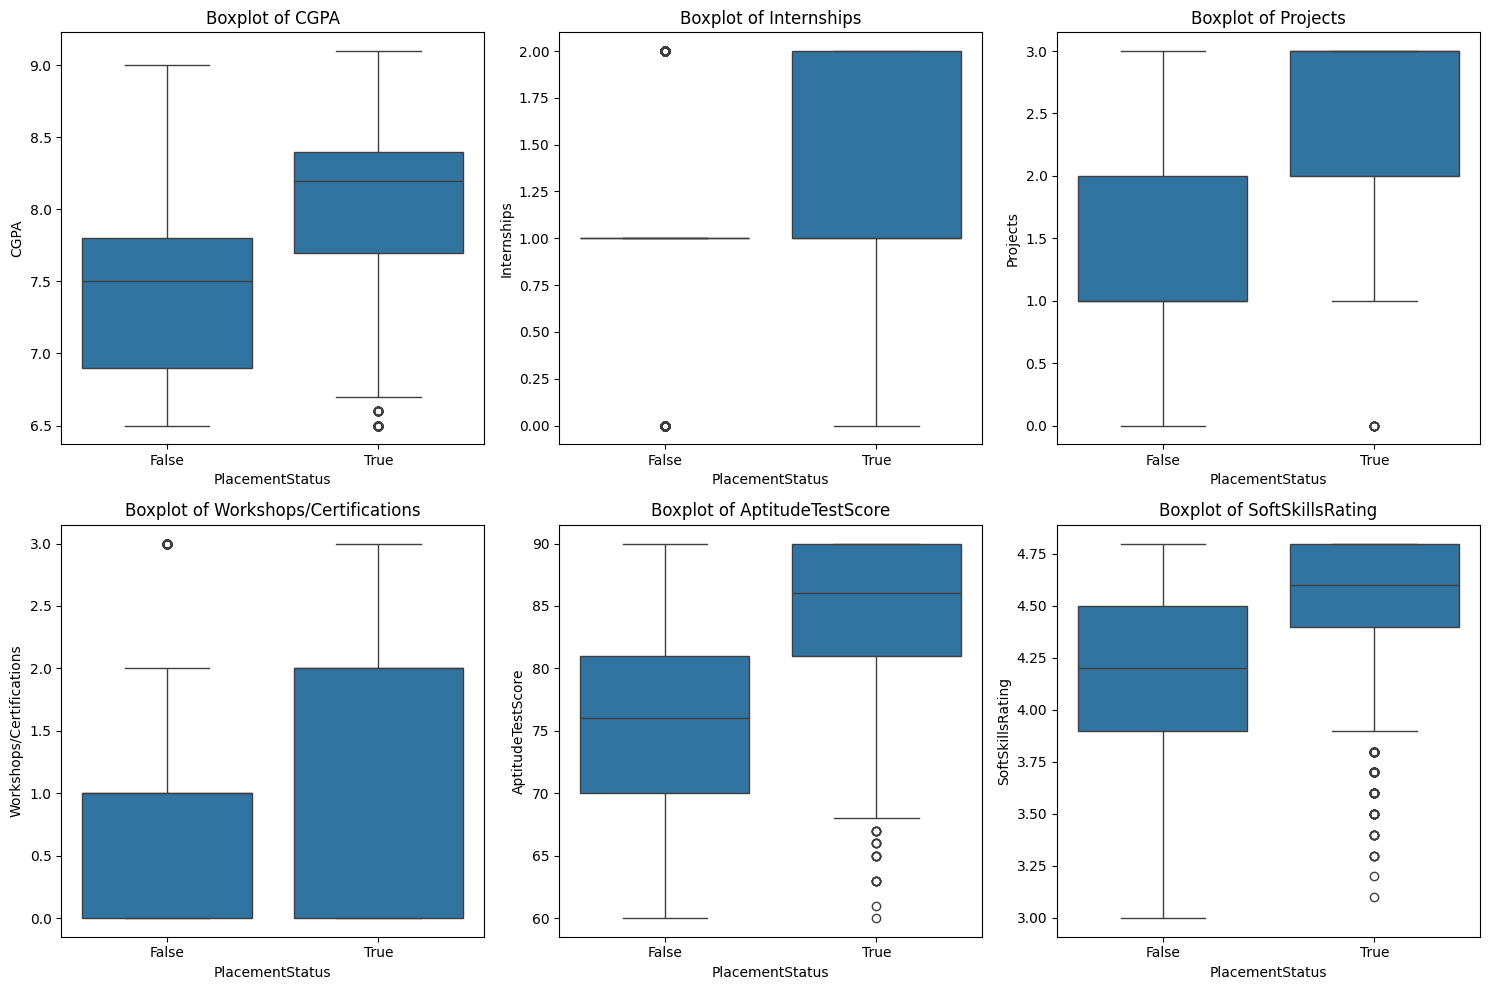

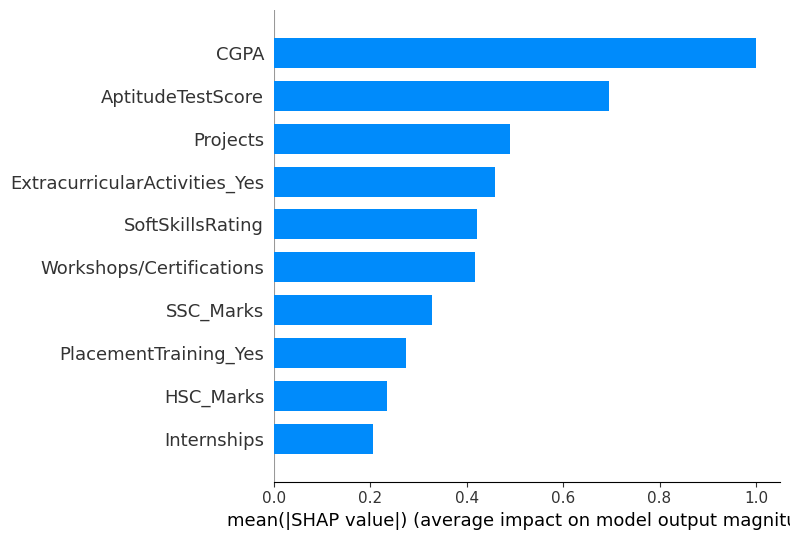

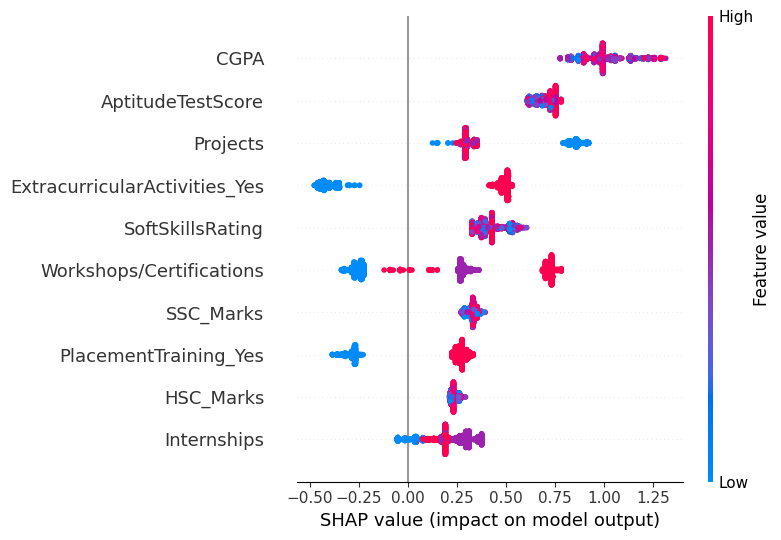

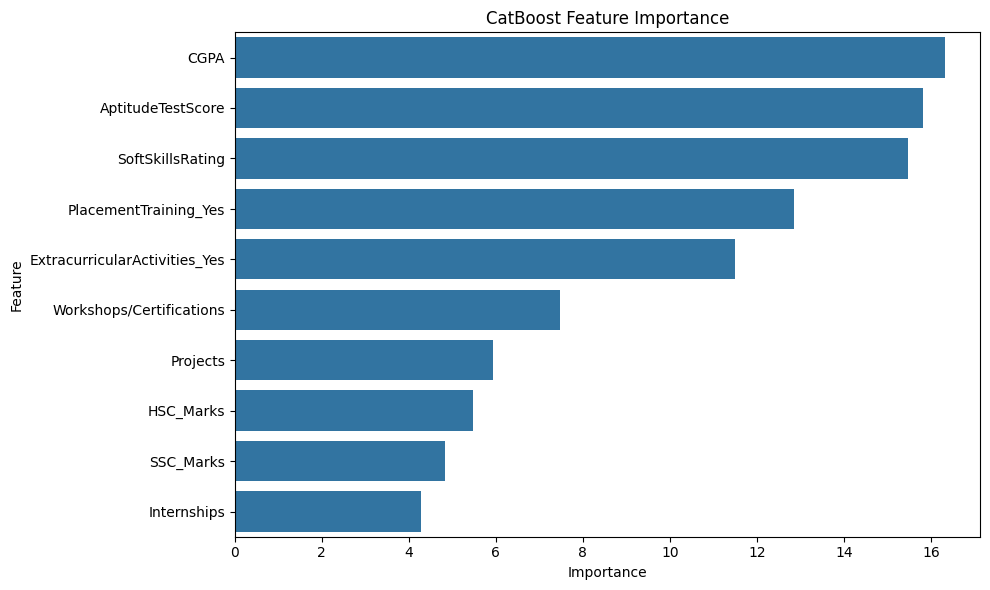

In [ ]:
# 📊 DATA VISUALIZATION MODULE for Campus Recruitment (FIXED)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap
import numpy as np

# ---------- Make sure we have feature names ----------
# Try to take from original X (if it exists). Otherwise, fall back to the known column list.
try:
    feature_names = X.columns.tolist()
except NameError:
    feature_names = [
        'CGPA','Internships','Projects','Workshops/Certifications',
        'AptitudeTestScore','SoftSkillsRating','ExtracurricularActivities',
        'PlacementTraining','SSC_Marks','HSC_Marks'
    ]

# ---------- Convert arrays back to DataFrames with names ----------
if isinstance(X_train, pd.DataFrame):
    X_train_df = X_train.copy()
else:
    X_train_df = pd.DataFrame(X_train, columns=feature_names)

if isinstance(X_test, pd.DataFrame):
    X_test_df = X_test.copy()
else:
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Combine X and y for easier plotting
df_train = X_train_df.copy()
df_train['PlacementStatus'] = (y_train if isinstance(y_train, pd.Series) else pd.Series(y_train, index=df_train.index))

# =============================
# 1️⃣ Class Distribution
# =============================
plt.figure(figsize=(5,4))
sns.countplot(x='PlacementStatus', data=df_train)
plt.title("Class Distribution (0 = Not Placed, 1 = Placed)")
plt.xlabel("Placement Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# =============================
# 2️⃣ Correlation Heatmap
# =============================
plt.figure(figsize=(12,8))
correlation = df_train.corr(numeric_only=True)
sns.heatmap(correlation, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# =============================
# 3️⃣ Feature Distributions
# =============================
num_cols = X_train_df.select_dtypes(include=[np.number]).columns
X_train_df[num_cols].hist(figsize=(15,12), bins=20)
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# =============================
# 4️⃣ Boxplots (Identify Outliers)
# =============================
plt.figure(figsize=(15,10))
for idx, col in enumerate(num_cols[:6]):  # limit to first 6 numeric features for clarity
    plt.subplot(2,3,idx+1)
    sns.boxplot(x='PlacementStatus', y=col, data=df_train)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# =============================
# 5️⃣ SHAP Feature Importance
# =============================
# Use DataFrame so SHAP shows real feature names
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_test_df)

# Bar chart of feature importance (SHAP)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Beeswarm plot with names
shap.summary_plot(shap_values, X_test_df)

# =============================
# 6️⃣ CatBoost Native Feature Importance
# =============================
importances = cat_model.get_feature_importance()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("CatBoost Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import shap

# --------- 1) Ensure we have feature names and DataFrames ---------
try:
    feature_names = X.columns.tolist()          # if original X exists
except NameError:
    feature_names = [
        'CGPA','Internships','Projects','Workshops/Certifications',
        'AptitudeTestScore','SoftSkillsRating','ExtracurricularActivities',
        'PlacementTraining','SSC_Marks','HSC_Marks'
    ]

# Wrap arrays into DataFrames so SHAP/LIME/plots show real names
X_train_df = X_train if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train, columns=feature_names)
X_test_df  = X_test  if isinstance(X_test,  pd.DataFrame) else pd.DataFrame(X_test,  columns=feature_names)

# --------- 2) SHAP explainer on the trained CatBoost model ---------
explainer = shap.Explainer(cat_model)          # CatBoost is tree-based; default works well
shap_values = explainer(X_test_df)             # Pass DataFrame to retain names

# --------- 3) Natural-language explanation generator ---------
def explain_prediction(index, shap_values, X_df, y_pred_labels, model):
    """
    index: row index in X_test_df
    shap_values: shap.Explanation returned by explainer(X_test_df)
    X_df: pandas DataFrame (X_test_df) with named columns
    y_pred_labels: 1D array of predicted class labels (0/1)
    model: trained CatBoost model (for probabilities)
    """
    # SHAP contributions for this row
    contrib = pd.DataFrame({
        'Feature': X_df.columns,
        'Value':   X_df.iloc[index].values,
        'SHAP':    shap_values.values[index]
    })
    # sort by absolute impact
    contrib_sorted = contrib.reindex(contrib['SHAP'].abs().sort_values(ascending=False).index)

    top_pos = contrib_sorted[contrib_sorted['SHAP'] > 0].head(3)
    top_neg = contrib_sorted[contrib_sorted['SHAP'] < 0].head(3)

    pred_label = int(y_pred_labels[index])
    pred_text  = "Placed" if pred_label == 1 else "Not Placed"

    # probs
    probs = model.predict_proba(X_df.iloc[[index]])[0]
    pred_conf = probs[pred_label]

    parts = [f"Candidate was predicted as **{pred_text}** (confidence {pred_conf:.2%}) mainly because "]

    reasons = []
    if len(top_pos):
        reasons.append(
            "positive impact from " +
            ", ".join([f"{r.Feature} ({r.Value})" for _, r in top_pos.iterrows()])
        )
    if len(top_neg):
        reasons.append(
            "negative impact from " +
            ", ".join([f"{r.Feature} ({r.Value})" for _, r in top_neg.iterrows()])
        )

    explanation = (", while ".join(reasons) + ".") if reasons else "the features had mixed/low influence."

    # Optional: return both text and the top tables if you want to display later
    return explanation, top_pos, top_neg

# --------- 4) Predictions (labels + probs) in correct CatBoost way ---------
# CatBoost .predict returns class labels directly (0/1). Ensure 1D int array.
y_pred_labels = np.asarray(cat_model.predict(X_test_df)).astype(int).ravel()

# Example usage:
idx = 0  # choose any test index
text, top_pos, top_neg = explain_prediction(idx, shap_values, X_test_df, y_pred_labels, cat_model)
print(text)

# Optional: visual SHAP for the same row
# shap.plots.waterfall(shap_values[idx])  # works because shap_values is Explanation with names

positive impact from CGPA (7.6), Projects (1), AptitudeTestScore (60), while negative impact from ExtracurricularActivities_Yes (False).


In [ ]:
# ✅ Store feature names right after creating X
original_feature_names = X.columns.tolist()

# --- your train-test split code ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Step 1: Ensure X_test is a DataFrame for SHAP
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=original_feature_names)

# ✅ Step 2: Generate explanation
candidate_index = 0  # Change index to test
shap_values_single = explainer(X_test.iloc[[candidate_index]])
predicted_class = "Placed" if cat_model.predict(X_test.iloc[[candidate_index]])[0] > 0.5 else "Not Placed"

# Get top features
abs_shap_values = np.abs(shap_values_single.values[0])
top_pos_idx = np.argsort(shap_values_single.values[0])[-2:]
top_neg_idx = np.argsort(shap_values_single.values[0])[:1]

top_pos_feats = [(original_feature_names[i], X_test.iloc[candidate_index, i], shap_values_single.values[0][i]) for i in top_pos_idx]
top_neg_feats = [(original_feature_names[i], X_test.iloc[candidate_index, i], shap_values_single.values[0][i]) for i in top_neg_idx]

# ✅ Step 3: Build HR-friendly explanation
reason = f"Candidate was predicted as {predicted_class} mainly because "
reason += " and ".join([f"{feat} ({val}) had a strong positive impact" for feat, val, _ in top_pos_feats])
reason += ", while "
reason += " and ".join([f"{feat} ({val}) slightly reduced the chance" for feat, val, _ in top_neg_feats]) + "."

print(reason)

Candidate was predicted as Placed mainly because Projects (1) had a strong positive impact and CGPA (7.6) had a strong positive impact, while ExtracurricularActivities_Yes (False) slightly reduced the chance.


In [ ]:
# ----------------------
# Hybrid XAI + Calibration + Scenario Simulator Module
# ----------------------
import numpy as np
import pandas as pd
import shap
from lime import lime_tabular
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import NotFittedError

# ---------- CONFIG / ASSUMPTIONS ----------
# Required objects already in your notebook:
#  - cat_model         : trained CatBoostClassifier
#  - scaler            : fitted StandardScaler (or None if not used)
#  - label_encoder     : fitted LabelEncoder for target (optional for class names)
#  - X_train, X_test   : either pandas DataFrames or numpy arrays (training/test features)
#  - y_train, y_test   : training/test labels
#
# If X_test is numpy array and scaler exists, this module will reconstruct a DataFrame
# in original feature-space using `original_feature_names` (must exist or will be inferred).

# ---------- helper: reconstruct DataFrame (unscaled) ----------
def ensure_X_df(X, original_feature_names=None, scaler=None, invert_scaling=False):
    """
    Returns (X_df, X_raw_df)
    - X_df: DataFrame used for model input (scaled if your model expects scaled input)
    - X_raw_df: DataFrame in original feature units (unscaled) for readable explanations and scenario simulation.
    """
    # If user passed DataFrame already:
    if isinstance(X, pd.DataFrame):
        X_df = X.copy()
        X_raw_df = X_df.copy() if scaler is None else pd.DataFrame(scaler.inverse_transform(X_df), columns=X_df.columns) if invert_scaling else X_df.copy()
        return X_df, X_raw_df

    # else X is numpy array
    if original_feature_names is None:
        raise ValueError("original_feature_names is required when X is a numpy array. Set original_feature_names = X.columns.tolist() earlier.")
    X_df = pd.DataFrame(X, columns=original_feature_names)
    if scaler is not None and invert_scaling:
        try:
            X_raw = pd.DataFrame(scaler.inverse_transform(X_df), columns=original_feature_names)
        except Exception:
            # if scaler can't inverse (rare), just copy scaled as raw
            X_raw = X_df.copy()
    else:
        # If scaler is provided and model expects scaled data, X_df is scaled; reconstruct raw only if scaler and invert_scaling True
        X_raw = X_df.copy()
    return X_df, X_raw

# ---------- 1) Calibration ----------
def get_calibrated_model(base_model, X_calib, y_calib, method='sigmoid'):
    """
    Calibrates probabilities for base_model. If base_model is already fitted, uses cv='prefit'.
    method: 'sigmoid' (Platt) or 'isotonic'
    Returns calibrated_clf (CalibratedClassifierCV)
    """
    try:
        # try prefit mode
        calibrated = CalibratedClassifierCV(base_estimator=base_model, method=method, cv='prefit')
        calibrated.fit(X_calib, y_calib)
        return calibrated
    except Exception:
        # fallback: fit with internal CV (slower) on training set
        calibrated = CalibratedClassifierCV(base_estimator=base_model, method=method, cv=3)
        calibrated.fit(X_calib, y_calib)
        return calibrated

# ---------- 2) SHAP & LIME initializers ----------
def init_shap_explainer(model, X_background):
    # TreeExplainer works well for CatBoost
    return shap.Explainer(model, X_background)

def init_lime_explainer(X_train_df, feature_names, class_names):
    return lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train_df),
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )

# ---------- 3) Per-instance explanation generator (merged SHAP+LIME + human text) ----------
def merged_explanation(index,
                       shap_explainer, shap_values,
                       lime_explainer,
                       X_df, X_raw_df,
                       calibrated_clf,
                       top_k_shap=3, top_k_lime=3):
    """
    index: integer index in X_df (or X_raw_df)
    returns: dict with 'text' (HR sentence), 'shap_table', 'lime_list', 'prob', 'band'
    """
    # Ensure X_df is DataFrame
    row = X_df.iloc[index:index+1]           # model input (scaled if required)
    row_raw = X_raw_df.iloc[index:index+1]   # human readable values

    # SHAP per-instance explanation (Explanation object)
    sv = shap_explainer(row)  # shap.Explanation
    shap_vals = sv.values[0]  # array per feature

    # build DataFrame for SHAP contributions
    shap_df = pd.DataFrame({
        'feature': X_df.columns,
        'value': row_raw.values.flatten(),
        'shap': shap_vals
    })
    shap_df['abs_shap'] = np.abs(shap_df['shap'])
    shap_df_sorted = shap_df.sort_values('abs_shap', ascending=False)

    # top contributors by SHAP
    top_shap = shap_df_sorted.head(top_k_shap)

    # LIME explanation
    lime_exp = lime_explainer.explain_instance(row.values.flatten(), calibrated_clf.predict_proba, num_features=top_k_lime)
    lime_list = lime_exp.as_list()  # list of (feature_str, weight)
    # parse LIME names (they come like "CGPA <= 7.5" or "Internships = 1")
    lime_features = []
    for feat_str, weight in lime_list:
        # try to extract feature name before space or comparator
        # common separators: ' <= ', ' > ', ' = ', ' in ', ' >='
        sep_tokens = [' <= ', ' >= ', ' < ', ' > ', ' = ', ' in ']
        fname = feat_str
        for t in sep_tokens:
            if t in feat_str:
                fname = feat_str.split(t)[0]
                break
        lime_features.append((fname.strip(), weight))

    # Merge SHAP + LIME: count agreement and pick top positives/negatives
    merged = shap_df.copy()
    merged['lime_weight'] = merged['feature'].map({f: w for f, w in lime_features}).fillna(0.0)

    # positive and negative contributors by SHAP sign
    pos = merged[merged['shap'] > 0].sort_values('abs_shap', ascending=False)
    neg = merged[merged['shap'] < 0].sort_values('abs_shap', ascending=False)

    # Compose HR-friendly sentence
    # Use top 2 pos and top 1 neg if available
    pos_list = [f"{row_raw.iloc[0][i]:.2f}" if isinstance(row_raw.iloc[0][i], (float, np.floating)) else str(row_raw.iloc[0][i])
                for i in [merged[merged['shap']>0].index.tolist()[j] for j in range(min(2, (merged['shap']>0).sum()))]] \
               if (merged['shap']>0).sum()>0 else []
    # but above approach is fragile: instead build strings from pos/neg DataFrames
    pos_feats = []
    for _, r in pos.head(2).iterrows():
        val = r['value']
        val_str = f"{val:.2f}" if isinstance(val, (float, np.floating)) else str(val)
        pos_feats.append(f"{r['feature']} ({val_str})")

    neg_feats = []
    for _, r in neg.head(1).iterrows():
        val = r['value']
        val_str = f"{val:.2f}" if isinstance(val, (float, np.floating)) else str(val)
        neg_feats.append(f"{r['feature']} ({val_str})")

    # Prediction + calibrated prob
    prob = calibrated_clf.predict_proba(row)[0][1]  # prob of positive class
    pred_label = int(calibrated_clf.predict(row)[0])
    pred_text = "Placed" if pred_label == 1 else "Not Placed"

    # Confidence band
    if prob >= 0.85:
        band = "High"
    elif prob >= 0.65:
        band = "Medium"
    else:
        band = "Low"

    # Build final natural-language sentence
    if len(pos_feats) > 0 and len(neg_feats) > 0:
        text = (f"Candidate was predicted as {pred_text} (probability {prob:.2%}, {band} confidence) mainly because "
                f"{' and '.join(pos_feats)} had a strong positive impact, while {neg_feats[0]} slightly reduced the chance.")
    elif len(pos_feats) > 0:
        text = (f"Candidate was predicted as {pred_text} (probability {prob:.2%}, {band} confidence) mainly because "
                f"{' and '.join(pos_feats)} had a strong positive impact.")
    elif len(neg_feats) > 0:
        text = (f"Candidate was predicted as {pred_text} (probability {prob:.2%}, {band} confidence) mainly because "
                f"{neg_feats[0]} had a strong negative impact.")
    else:
        text = f"Candidate was predicted as {pred_text} (probability {prob:.2%}, {band} confidence)."

    # Return lots of info for downstream use
    return {
        'text': text,
        'probability': prob,
        'confidence_band': band,
        'top_shap': top_shap.reset_index(drop=True),
        'lime_list': lime_features,
        'shap_table': shap_df_sorted.reset_index(drop=True)
    }

# ---------- 4) Scenario simulation ----------
def simulate_scenario(index, changes: dict,
                      X_df, X_raw_df,
                      shap_explainer, lime_explainer, calibrated_clf):
    """
    index: index to base scenario on (int)
    changes: dict of {feature_name: new_value}  where new_value is in RAW units (not scaled)
    Returns new prediction, new explanation dict
    """
    # copy raw row
    row_raw = X_raw_df.iloc[index:index+1].copy()
    # apply changes
    for k, v in changes.items():
        if k not in row_raw.columns:
            raise KeyError(f"Feature {k} not found in data columns.")
        row_raw.loc[row_raw.index[0], k] = v

    # convert to model input (scale if scaler available)
    # If scaler exists, we assume scaler.transform expects columns in same order
    if 'scaler' in globals() and scaler is not None:
        row_scaled = pd.DataFrame(scaler.transform(row_raw), columns=row_raw.columns)
    else:
        row_scaled = row_raw.copy()

    # Build explanation using merged_explanation (we need DataFrames X_df-like and X_raw_df-like with index 0)
    # We'll create temp X_df/X_raw_df of single row and call merged_explanation with index 0
    temp_X_df = row_scaled.reset_index(drop=True)
    temp_X_raw = row_raw.reset_index(drop=True)

    # Recompute shap values for this single row using explainer on background + row (explainer expects array/dataframe)
    # Note: shap_explainer can take temp_X_df directly
    # Use merged_explanation but it expects shap_values computed for dataset; we can compute shap_explainer(temp_X_df)
    temp_shap_values = shap_explainer(temp_X_df)

    # Use merged_explanation but it expects shap_values computed for whole dataset; we pass temp_shap_values and index 0
    return merged_explanation(0, shap_explainer, temp_shap_values, lime_explainer, temp_X_df, temp_X_raw, calibrated_clf)


# ---------- USAGE EXAMPLE ----------
# Prepare DataFrames (convert arrays to DataFrames if needed)
# Make sure original_feature_names exists (from earlier: original_feature_names = X.columns.tolist())
original_feature_names = original_feature_names if 'original_feature_names' in globals() else X.columns.tolist()

In [ ]:
candidate_index = 0  # Change to view other candidates

# ✅ Get the prediction
y_pred_class = (cat_model.predict(X_test) > 0.5).astype(int)

# ✅ Extract SHAP values for one candidate
shap_values_candidate = shap_values.values[candidate_index]  # .values fixes the error

# ✅ Sort features by absolute SHAP impact
sorted_features = sorted(
    zip(original_feature_names, shap_values_candidate, X_test.iloc[candidate_index]),
    key=lambda x: abs(x[1]),
    reverse=True
)

# ✅ Create HR-friendly message
prediction_label = "Placed" if y_pred_class[candidate_index] == 1 else "Not Placed"
message_parts = []
for feat, impact, value in sorted_features[:3]:  # Top 3 factors
    if impact > 0:
        message_parts.append(f"{feat} ({value}) had a strong positive impact")
    else:
        message_parts.append(f"{feat} ({value}) slightly reduced the chance")

final_message = (
    f"Candidate was predicted as {prediction_label} mainly because "
    + ", while ".join(message_parts)
)
print(final_message)

Candidate was predicted as Placed mainly because CGPA (7.6) had a strong positive impact, while Projects (1) had a strong positive impact, while AptitudeTestScore (60) had a strong positive impact


In [ ]:
candidate_index = 0  # Index of the candidate to explain

# Get predicted class
y_pred_class = (cat_model.predict(X_test) > 0.5).astype(int)

# Extract SHAP values for this candidate (fix for new SHAP)
shap_values_candidate = shap_values.values[candidate_index]

# Sort features by absolute SHAP contribution
sorted_features = sorted(
    zip(original_feature_names, shap_values_candidate, X_test.iloc[candidate_index]),
    key=lambda x: abs(x[1]),
    reverse=True
)

# Build HR-friendly formatted explanation
prediction_label = "Placed" if y_pred_class[candidate_index] == 1 else "Not Placed"
print(f"Prediction: {prediction_label}")
print("Top factors influencing the decision:")

for i, (feat, impact, value) in enumerate(sorted_features[:5], start=1):  # top 5 features
    impact_sign = "+" if impact > 0 else "-"
    impact_strength = abs(impact)
    if impact_strength > 0.3:
        strength_label = "Strong"
    elif impact_strength > 0.15:
        strength_label = "Moderate"
    else:
        strength_label = "Slight"

    print(f"{i}. {feat} ({value}) — {strength_label} {'positive' if impact > 0 else 'negative'} impact ({impact_sign}{impact_strength:.2f})")

Prediction: Placed
Top factors influencing the decision:
1. CGPA (7.6) — Strong positive impact (+0.95)
2. Projects (1) — Strong positive impact (+0.83)
3. AptitudeTestScore (60) — Strong positive impact (+0.61)
4. ExtracurricularActivities_Yes (False) — Strong negative impact (-0.44)
5. SoftSkillsRating (4.4) — Strong positive impact (+0.40)


In [ ]:
import numpy as np

# ✅ Helper for formatting values
def format_val(v):
    return f"{v:+.2f}" if v is not None else "N/A"

# 🔹 Pick candidate to explain
candidate_index = 0

# 🔹 Get SHAP explanation for one sample
shap_values_candidate = (
    shap_values[candidate_index].values
    if hasattr(shap_values[candidate_index], 'values')
    else shap_values[candidate_index]
)

# 🔹 Get LIME explanation
lime_explanation = lime_exp.as_list()  # [(feature, weight), ...]

# 🔹 Merge SHAP + LIME contributions by feature
feature_contributions = {}
for feature, shap_val in zip(original_feature_names, shap_values_candidate):
    feature_contributions[feature] = {"shap": shap_val, "lime": None}

for feature, lime_val in lime_explanation:
    clean_feature = feature.split()[0]  # cleanup name for match
    if clean_feature in feature_contributions:
        feature_contributions[clean_feature]["lime"] = lime_val

# 🔹 Sort by average impact (SHAP+LIME if available)
sorted_features = sorted(
    feature_contributions.items(),
    key=lambda x: abs(np.nanmean([v for v in [x[1]['shap'], x[1]['lime']] if v is not None])),
    reverse=True
)

# 🔹 Print top 5 explainability contributions
print("\n🔍 Hybrid Explainability for Candidate #{}:".format(candidate_index))
for feat, vals in sorted_features[:5]:
    shap_c = format_val(vals['shap'])
    lime_c = format_val(vals['lime'])
    print(f"• {feat}: SHAP {shap_c}, LIME {lime_c}")

# 🔹 HR-friendly summary
# (Option 1: pick absolute top feature, even if LIME missing)
top_feat, vals = sorted_features[0]

print(f"\n📢 HR Summary: SHAP and LIME suggest that **{top_feat}** is the most important factor, "
      f"with contributions {format_val(vals['shap'])} (SHAP) and {format_val(vals['lime'])} (LIME) "
      f"to the placement probability.")

# (Option 2: pick only features where both SHAP & LIME exist)
both_explained = [(f, v) for f, v in sorted_features if v['shap'] is not None and v['lime'] is not None]
if both_explained:
    top_feat_both, vals_both = both_explained[0]
    print(f"\n✅ Alternative HR Summary (both SHAP & LIME available): "
          f"**{top_feat_both}** is consistently important, with "
          f"{format_val(vals_both['shap'])} (SHAP) and {format_val(vals_both['lime'])} (LIME).")



🔍 Hybrid Explainability for Candidate #0:
• Projects: SHAP +0.83, LIME N/A
• CGPA: SHAP +0.95, LIME +0.11
• ExtracurricularActivities_Yes: SHAP -0.44, LIME N/A
• AptitudeTestScore: SHAP +0.61, LIME +0.16
• Workshops/Certifications: SHAP +0.27, LIME N/A

📢 HR Summary: SHAP and LIME suggest that **Projects** is the most important factor, with contributions +0.83 (SHAP) and N/A (LIME) to the placement probability.

✅ Alternative HR Summary (both SHAP & LIME available): **CGPA** is consistently important, with +0.95 (SHAP) and +0.11 (LIME).


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Use your trained model (replace 'cat_model' if you named it differently)
calibrated_model = CalibratedClassifierCV(cat_model, method='isotonic', cv=5)

# Fit the calibrated model on the training data
calibrated_model.fit(X_train, y_train)

# Example candidate index for explanation (adjust as needed)
candidate_index = 0

# Predict calibrated probabilities for the candidate
proba = calibrated_model.predict_proba(X_test)[candidate_index, 1]

# Assign confidence label
if proba >= 0.80:
    conf_label = "High Confidence"
elif proba >= 0.60:
    conf_label = "Medium Confidence"
else:
    conf_label = "Low Confidence"

print(f"🎯 Placement Likelihood: {proba*100:.1f}% ({conf_label})")

0:	learn: 0.6659998	total: 2.14ms	remaining: 1.07s
100:	learn: 0.3785915	total: 194ms	remaining: 766ms
200:	learn: 0.3442426	total: 381ms	remaining: 567ms
300:	learn: 0.3138361	total: 588ms	remaining: 388ms
400:	learn: 0.2898711	total: 785ms	remaining: 194ms
499:	learn: 0.2664373	total: 973ms	remaining: 0us
0:	learn: 0.6655329	total: 2.51ms	remaining: 1.25s
100:	learn: 0.3798941	total: 199ms	remaining: 786ms
200:	learn: 0.3435526	total: 397ms	remaining: 591ms
300:	learn: 0.3087679	total: 604ms	remaining: 399ms
400:	learn: 0.2823682	total: 787ms	remaining: 194ms
499:	learn: 0.2586694	total: 967ms	remaining: 0us
0:	learn: 0.6655215	total: 2.03ms	remaining: 1.01s
100:	learn: 0.3804719	total: 233ms	remaining: 920ms
200:	learn: 0.3447539	total: 651ms	remaining: 969ms
300:	learn: 0.3118951	total: 1.07s	remaining: 705ms
400:	learn: 0.2850200	total: 1.47s	remaining: 363ms
499:	learn: 0.2625679	total: 1.79s	remaining: 0us
0:	learn: 0.6641187	total: 5.92ms	remaining: 2.95s
100:	learn: 0.3689289	

In [ ]:
def simulate_scenario(candidate_idx, feature, new_value):
    # Copy candidate's original data
    new_data = X_test.iloc[candidate_idx].copy()

    # Modify the selected feature
    new_data[feature] = new_value

    # Convert to DataFrame with the same columns as training data
    new_data_df = pd.DataFrame([new_data], columns=X_test.columns)

    # Predict new probability
    new_proba = calibrated_model.predict_proba(new_data_df)[0, 1]
    return new_proba

# Example
candidate_index = 0  # select candidate
old_proba = calibrated_model.predict_proba(X_test.iloc[[candidate_index]])[0, 1]
new_proba = simulate_scenario(candidate_index, "CGPA", 8.0)

print(f"📈 If CGPA improves, probability changes from {old_proba*100:.1f}% to {new_proba*100:.1f}%")

📈 If CGPA improves, probability changes from 2.6% to 2.6%


✅ Test Accuracy: 79.17%
AUC: 0.884

Classification Report:
               precision    recall  f1-score   support

   NotPlaced       0.81      0.84      0.82       839
      Placed       0.76      0.73      0.75       606

    accuracy                           0.79      1445
   macro avg       0.79      0.78      0.78      1445
weighted avg       0.79      0.79      0.79      1445

Confusion Matrix:
 [[702 137]
 [164 442]]

==================== Candidate Decision ====================
Prediction: Placed
Placement Probability: 52.0% (Low confidence)
Decision Threshold: 0.50

Top contributing features (SHAP):
 • SSC_Marks: +0.406 (↑ helped placement) — value: 82
 • CGPA: +0.399 (↑ helped placement) — value: 8.5
 • HSC_Marks: +0.369 (↑ helped placement) — value: 84
 • AptitudeTestScore: -0.363 (↓ reduced placement) — value: 78
 • Workshops/Certifications: -0.279 (↓ reduced placement) — value: 1
 • ExtracurricularActivities: +0.241 (↑ helped placement) — value: Yes
 • PlacementTraining: +

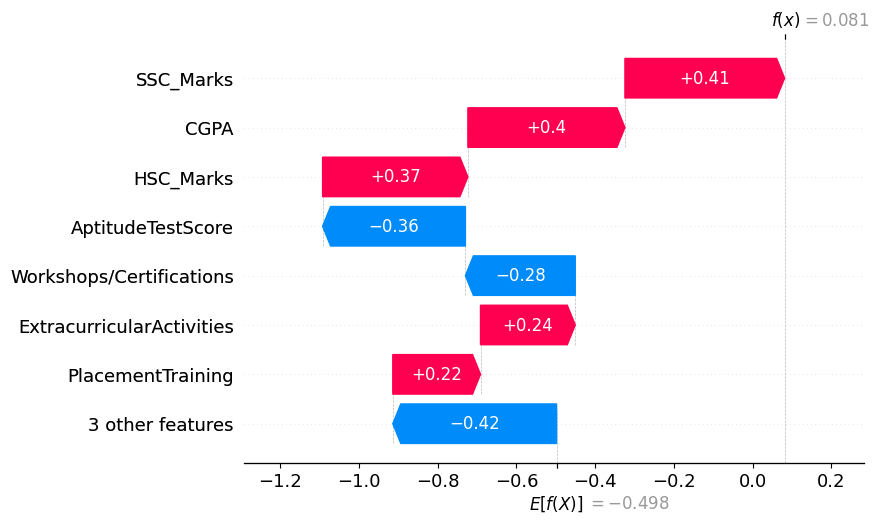

In [ ]:
# ============================================================
# Campus Placement — CatBoost + SHAP EXPLAINABLE AI PIPELINE
# ============================================================

import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import shap
import warnings

warnings.filterwarnings("ignore")

# =========================
# 0) CONFIG / FILE PATH
# =========================
CSV_PATH = "/content/campus_recruitment.csv"   # <-- update path if needed

# =========================
# 1) LOAD & CLEAN DATA
# =========================
df = pd.read_csv(CSV_PATH)

# Expect: "PlacementStatus" contains "Placed"/"NotPlaced"
if "PlacementStatus" not in df.columns:
    raise ValueError("Expected a 'PlacementStatus' column in the CSV.")

# Normalize strings
df["PlacementStatus"] = (
    df["PlacementStatus"].astype(str).str.strip().str.lower()
)

# Map target to 0/1
target_map = {
    "placed": 1, "notplaced": 0,  # your dataset strings
    "1": 1, "0": 0,
    "yes": 1, "no": 0, "true": 1, "false": 0
}
df["PlacementStatus"] = df["PlacementStatus"].map(target_map)

# Drop rows where target couldn't be mapped
df = df.dropna(subset=["PlacementStatus"]).copy()
df["PlacementStatus"] = df["PlacementStatus"].astype(int)

# Basic sanity check: need both classes to actually train
if df["PlacementStatus"].nunique() < 2:
    raise ValueError("Dataset has only one class in 'PlacementStatus'. Add both Placed and NotPlaced rows.")

# Identify columns
target_col = "PlacementStatus"
all_cols = df.columns.tolist()
feature_cols = [c for c in all_cols if c != target_col]

# Known categorical columns in your schema
known_cats = ["ExtracurricularActivities", "PlacementTraining"]
cat_cols = [c for c in feature_cols if c in known_cats or df[c].dtype == "object"]
num_cols = [c for c in feature_cols if c not in cat_cols]

# Clean numerics: coerce + impute median
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df[c].fillna(df[c].median())

# Clean categoricals: make strings, normalize Yes/No
def norm_cat(s):
    s = s.astype(str).str.strip()
    s_lower = s.str.lower()
    mapped = np.where(s_lower.isin(["yes","y","1","true"]), "Yes",
             np.where(s_lower.isin(["no","n","0","false"]), "No", s))
    return pd.Series(mapped, index=s.index)

for c in cat_cols:
    df[c] = norm_cat(df[c]).fillna("Missing").astype(str)

# Final X/y
X = df[feature_cols].copy()
y = df[target_col].copy()

# CatBoost needs categorical columns as indices (by position)
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

# =========================
# 2) TRAIN / TEST SPLIT
# =========================
# Use stratify only if both classes present sufficiently
stratify_param = y if (y.nunique() > 1 and y.value_counts().min() >= 2) else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_param
)

# Pools for CatBoost
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)

# =========================
# 3) TRAIN CATBOOST
# =========================
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False
)
cat_model.fit(train_pool, eval_set=test_pool, verbose=False)

# =========================
# 4) EVALUATE
# =========================
y_pred = cat_model.predict(test_pool)
y_proba = cat_model.predict_proba(test_pool)[:, 1]
print("✅ Test Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["NotPlaced","Placed"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# =========================
# 5) SHAP EXPLAINER
# =========================
# For CatBoost, TreeExplainer + Pool works well
shap_explainer = shap.TreeExplainer(cat_model)

# =========================
# 6) UTILITIES
# =========================
# Build a one-row DataFrame for a candidate in the exact feature order/types
def build_candidate_row(user_dict: dict) -> pd.DataFrame:
    # Start from training medians/modes to ensure all features exist
    row = {}
    # numeric defaults = train median
    for c in num_cols:
        row[c] = float(np.round(X_train[c].median(), 3))
    # categorical defaults = train mode
    for c in cat_cols:
        row[c] = str(X_train[c].mode(dropna=True).iloc[0])

    # Update with provided values
    for k, v in user_dict.items():
        if k not in X.columns:
            raise ValueError(f"Unknown feature '{k}'. Expected one of: {list(X.columns)}")
        row[k] = v

    # Type/format alignment
    df_row = pd.DataFrame([row], columns=X.columns)

    for c in num_cols:
        df_row[c] = pd.to_numeric(df_row[c], errors="coerce").fillna(X_train[c].median())

    for c in cat_cols:
        df_row[c] = norm_cat(df_row[c].astype(str)).fillna("Missing").astype(str)

    return df_row

def _confidence(p: float) -> str:
    return "High" if p >= 0.8 else ("Medium" if p >= 0.6 else "Low")

# Tiny “what-if” nudge helper for numeric features
def suggest_nudges(x_row: pd.DataFrame, k=3):
    # Try small, realistic moves toward favorable quantiles
    # We’ll only check a few important numeric features to keep it fast.
    baseline = cat_model.predict_proba(Pool(x_row, cat_features=cat_idx))[0, 1]
    suggestions = []

    # Candidate-specific ranks
    q75 = X_train[num_cols].quantile(0.75)
    q90 = X_train[num_cols].quantile(0.90)

    for c in num_cols:
        current = float(x_row.iloc[0][c])
        targets = []
        # If the feature looks like a score/marks/CGPA, try nudging upwards
        if c.lower() in ["cgpa", "aptitudetestscore", "ssc_marks", "hsc_marks", "softskillsrating"]:
            targets = [max(current, q75.get(c, current)), max(current, q90.get(c, current))]
        else:
            # For counts like Projects/Internships/Workshops, try +1 / +2
            targets = [current + 1, current + 2]

        for t in targets:
            test_row = x_row.copy()
            test_row[c] = t
            proba = cat_model.predict_proba(Pool(test_row, cat_features=cat_idx))[0, 1]
            suggestions.append((c, current, t, proba - baseline))

    # Top positive changes
    suggestions = sorted(suggestions, key=lambda z: z[3], reverse=True)
    return [(c, old, new, float(delta)) for (c, old, new, delta) in suggestions[:k] if delta > 0.0]

# =========================
# 7) EXPLAIN A CANDIDATE
# =========================
def explain_candidate(user_dict: dict, threshold: float = 0.5, top_k: int = 8, try_nudges: bool = True):
    """
    user_dict: {"CGPA": 8.2, "Internships": 1, "Projects": 2, ...}
               include only the fields you want to override; missing ones are filled with medians/modes.
    """
    # Build aligned row
    x_row = build_candidate_row(user_dict)

    # Prediction
    proba = cat_model.predict_proba(Pool(x_row, cat_features=cat_idx))[0, 1]
    label = int(proba >= threshold)
    direction = "Placed" if label == 1 else "Not Placed"
    print("\n==================== Candidate Decision ====================")
    print(f"Prediction: {direction}")
    print(f"Placement Probability: {proba*100:.1f}% ({_confidence(proba)} confidence)")
    print(f"Decision Threshold: {threshold:.2f}")
    print("============================================================")

    # SHAP local explanation
    # With CatBoost + TreeExplainer, pass a Pool to shap_values for consistent cat handling.
    local_shap = shap_explainer.shap_values(Pool(x_row, cat_features=cat_idx))[0]
    contrib = pd.Series(local_shap, index=X.columns).sort_values(key=lambda s: s.abs(), ascending=False)

    print("\nTop contributing features (SHAP):")
    for feat, val in contrib.head(top_k).items():
        arrow = "↑" if val > 0 else "↓"
        effect = "helped placement" if val > 0 else "reduced placement"
        print(f" • {feat}: {val:+.3f} ({arrow} {effect}) — value: {x_row.iloc[0][feat]}")

    # Suggestions (most negative SHAP values)
    negatives = contrib[contrib < 0].head(5)
    if len(negatives) > 0:
        print("\nWhat to improve (based on SHAP):")
        for feat, val in negatives.items():
            if feat in num_cols:
                # Give a nudge hint using training quantiles
                higher = X_train[feat].quantile(0.75)
                print(f" • {feat}: {val:+.3f} → Raise toward ~{higher:.1f} (if feasible). Current: {x_row.iloc[0][feat]}")
            else:
                # Categorical hint
                print(f" • {feat}: {val:+.3f} → Consider switching category (if realistic). Current: {x_row.iloc[0][feat]}")

    # Optional: small “what-if” nudges that maximize probability gain
    if try_nudges:
        nudges = suggest_nudges(x_row, k=3)
        if nudges:
            print("\nHigh-impact, small 'what-if' changes:")
            for c, old, new, delta in nudges:
                print(f" • If {c} = {new} (from {old}), predicted placement ↑ by {delta*100:.1f} pts")
        else:
            print("\nNo small numeric changes found that clearly increase probability.")

    # Optional SHAP waterfall (best-effort; some envs don’t display figures)
    try:
        shap.plots._waterfall.waterfall_legacy(
            expected_value=shap_explainer.expected_value,
            shap_values=local_shap,
            feature_names=X.columns.tolist(),
            max_display=top_k
        )
    except Exception:
        pass

    # Return structured info if you want to use it programmatically
    return {
        "proba": float(proba),
        "pred_label": int(label),
        "direction": direction,
        "shap_contributions": contrib.to_dict()
    }

# =========================
# 8) EXAMPLE USAGE
# =========================
# Fill only what you know; the rest auto-fills with medians/modes from training.
example_candidate = {
    "CGPA": 8.5,
    "Internships": 1,
    "Projects": 2,
    "Workshops/Certifications": 1,
    "AptitudeTestScore": 78,
    "SoftSkillsRating": 4.2,
    "ExtracurricularActivities": "Yes",
    "PlacementTraining": "Yes",
    "SSC_Marks": 82,
    "HSC_Marks": 84
}

# Run the explainer
_ = explain_candidate(example_candidate, threshold=0.5, top_k=8, try_nudges=True)
